## Bayesian methods of hyperparameter optimization

In addition to the random search and the grid search methods for selecting optimal hyperparameters, we can use Bayesian methods of probabilities to select the optimal hyperparameters for an algorithm.

In this case study, we will be using the BayesianOptimization library to perform hyperparmater tuning. This library has very good documentation which you can find here: https://github.com/fmfn/BayesianOptimization

You will need to install the Bayesian optimization module. Running a cell with an exclamation point in the beginning of the command will run it as a shell command — please do this to install this module from our notebook in the cell below.

In [15]:
#!pip install bayesian-optimization

In [16]:
#!pip install lightgbm

In [17]:
#!pip install catboost

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

In [8]:
import os
os.listdir()

['flight_delays_test.csv.zip',
 '.DS_Store',
 'flight_delays_test.csv',
 'Bayesian_optimization_case_study.ipynb',
 'flight_delays_train.csv.zip',
 'flight_delays_train.csv',
 '.ipynb_checkpoints']

## How does Bayesian optimization work?

Bayesian optimization works by constructing a posterior distribution of functions (Gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

<img src="https://github.com/fmfn/BayesianOptimization/blob/master/examples/bo_example.png?raw=true" />
As you iterate over and over, the algorithm balances its needs of exploration and exploitation while taking into account what it knows about the target function. At each step, a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with an exploration strategy (such as UCB — aka Upper Confidence Bound), or EI (Expected Improvement). This process is used to determine the next point that should be explored (see the gif below).
<img src="https://github.com/fmfn/BayesianOptimization/raw/master/examples/bayesian_optimization.gif" />

## Let's look at a simple example

The first step is to create an optimizer. It uses two items:
* function to optimize
* bounds of parameters

The function is the procedure that counts metrics of our model quality. The important thing is that our optimization will maximize the value on function. Smaller metrics are best. Hint: don't forget to use negative metric values.

Here we define our simple function we want to optimize.

In [9]:
def simple_func(a, b):
    return a + b

Now, we define our bounds of the parameters to optimize, within the Bayesian optimizer.

In [18]:
BayesianOptimization??

In [10]:
optimizer = BayesianOptimization(
    simple_func,
    {'a': (1, 3),
    'b': (4, 7)})

These are the main parameters of this function:

* **n_iter:** This is how many steps of Bayesian optimization you want to perform. The more steps, the more likely you are to find a good maximum.

* **init_points:** This is how many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

Let's run an example where we use the optimizer to find the best values to maximize the target value for a and b given the inputs of 3 and 2.

In [11]:
optimizer.maximize(3,2)

|   iter    |  target   |     a     |     b     |
-------------------------------------------------
|  1        |  7.529    |  2.515    |  5.014    |
|  2        |  7.473    |  1.389    |  6.083    |
|  3        |  7.198    |  2.184    |  5.014    |
|  4        |  7.786    |  1.018    |  6.767    |
|  5        |  7.021    |  2.663    |  4.358    |


Great, now let's print the best parameters and the associated maximized target.

In [12]:
print(optimizer.max['params']);optimizer.max['target']

{'a': 1.0184669628441587, 'b': 6.767388835156321}


7.78585579800048

## Test it on real data using the Light GBM

The dataset we will be working with is the famous flight departures dataset. Our modeling goal will be to predict if a flight departure is going to be delayed by 15 minutes based on the other attributes in our dataset. As part of this modeling exercise, we will use Bayesian hyperparameter optimization to identify the best parameters for our model.

**<font color='teal'> You can load the zipped csv files just as you would regular csv files using Pandas read_csv. In the next cell load the train and test data into two seperate dataframes. </font>**


In [19]:
train_df = pd.read_csv('flight_delays_train.csv.zip')
test_df = pd.read_csv('flight_delays_test.csv.zip')

**<font color='teal'> Print the top five rows of the train dataframe and review the columns in the data. </font>**

In [20]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


**<font color='teal'> Use the describe function to review the numeric columns in the train dataframe. </font>**

In [21]:
train_df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


Notice, `DepTime` is the departure time in a numeric representation in 2400 hours. 

 **<font color='teal'>The response variable is 'dep_delayed_15min' which is a categorical column, so we need to map the Y for yes and N for no values to 1 and 0. Run the code in the next cell to do this.</font>**

In [22]:
#train_df = train_df[train_df.DepTime <= 2400].copy()
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

## Feature Engineering
Use these defined functions to create additional features for the model. Run the cell to add the functions to your workspace.

In [23]:
def label_enc(df_column):
    df_column = LabelEncoder().fit_transform(df_column)
    return df_column

def make_harmonic_features_sin(value, period=2400):
    value *= 2 * np.pi / period 
    return np.sin(value)

def make_harmonic_features_cos(value, period=2400):
    value *= 2 * np.pi / period 
    return np.cos(value)

def feature_eng(df):
    df['flight'] = df['Origin']+df['Dest']
    df['Month'] = df.Month.map(lambda x: x.split('-')[-1]).astype('int32')
    df['DayofMonth'] = df.DayofMonth.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['begin_of_month'] = (df['DayofMonth'] < 10).astype('uint8')
    df['midddle_of_month'] = ((df['DayofMonth'] >= 10)&(df['DayofMonth'] < 20)).astype('uint8')
    df['end_of_month'] = (df['DayofMonth'] >= 20).astype('uint8')
    df['DayOfWeek'] = df.DayOfWeek.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['hour'] = df.DepTime.map(lambda x: x/100).astype('int32')
    df['morning'] = df['hour'].map(lambda x: 1 if (x <= 11)& (x >= 7) else 0).astype('uint8')
    df['day'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <= 18) else 0).astype('uint8')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('uint8')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('int32')
    df['winter'] = df['Month'].map(lambda x: x in [12, 1, 2]).astype('int32')
    df['spring'] = df['Month'].map(lambda x: x in [3, 4, 5]).astype('int32')
    df['summer'] = df['Month'].map(lambda x: x in [6, 7, 8]).astype('int32')
    df['autumn'] = df['Month'].map(lambda x: x in [9, 10, 11]).astype('int32')
    df['holiday'] = (df['DayOfWeek'] >= 5).astype(int) 
    df['weekday'] = (df['DayOfWeek'] < 5).astype(int)
    df['airport_dest_per_month'] = df.groupby(['Dest', 'Month'])['Dest'].transform('count')
    df['airport_origin_per_month'] = df.groupby(['Origin', 'Month'])['Origin'].transform('count')
    df['airport_dest_count'] = df.groupby(['Dest'])['Dest'].transform('count')
    df['airport_origin_count'] = df.groupby(['Origin'])['Origin'].transform('count')
    df['carrier_count'] = df.groupby(['UniqueCarrier'])['Dest'].transform('count')
    df['carrier_count_per month'] = df.groupby(['UniqueCarrier', 'Month'])['Dest'].transform('count')
    df['deptime_cos'] = df['DepTime'].map(make_harmonic_features_cos)
    df['deptime_sin'] = df['DepTime'].map(make_harmonic_features_sin)
    df['flightUC'] = df['flight']+df['UniqueCarrier']
    df['DestUC'] = df['Dest']+df['UniqueCarrier']
    df['OriginUC'] = df['Origin']+df['UniqueCarrier']
    return df.drop('DepTime', axis=1)

Concatenate the training and testing dataframes.


In [24]:
full_df = pd.concat([train_df.drop('dep_delayed_15min', axis=1), test_df])
full_df = feature_eng(full_df)

Apply the earlier defined feature engineering functions to the full dataframe.

In [25]:
for column in ['UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']:
    full_df[column] = label_enc(full_df[column])

In [27]:
full_df.describe()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,flight,begin_of_month,midddle_of_month,...,airport_origin_per_month,airport_dest_count,airport_origin_count,carrier_count,carrier_count_per month,deptime_cos,deptime_sin,flightUC,DestUC,OriginUC
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,6.530710,15.702585,3.942155,12.970740,149.836020,149.993455,726.263635,2490.47673,0.296975,0.328635,...,314.742940,3766.161100,3756.379880,14533.067820,1214.917320,-0.373570,-0.129196,4265.495325,929.929995,922.064720
std,3.415164,8.792117,1.991469,6.804142,80.778194,80.852928,568.955768,1428.73465,0.456927,0.469718,...,264.690449,3170.049833,3157.551081,8144.726522,683.050928,0.551643,0.734471,2456.420996,539.120443,534.363589
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,446.000000,27.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,2.000000,7.000000,81.000000,81.000000,319.000000,1298.00000,0.000000,0.000000,...,108.000000,1341.000000,1305.000000,8701.000000,707.000000,-0.866025,-0.852640,2236.000000,486.000000,484.000000
50%,7.000000,16.000000,4.000000,14.000000,159.000000,159.000000,575.000000,2529.00000,0.000000,0.000000,...,264.000000,3019.000000,3029.000000,13311.000000,1127.000000,-0.502266,-0.311506,4310.000000,956.000000,949.000000
75%,9.000000,23.000000,6.000000,19.000000,214.000000,214.000000,954.000000,3713.00000,1.000000,1.000000,...,456.000000,5571.000000,5516.000000,15343.000000,1372.000000,-0.010472,0.641450,6377.000000,1357.000000,1341.000000
max,12.000000,31.000000,7.000000,22.000000,306.000000,306.000000,4962.000000,5047.00000,1.000000,1.000000,...,1019.000000,11382.000000,11387.000000,30958.000000,2728.000000,1.000000,1.000000,8592.000000,1955.000000,1943.000000


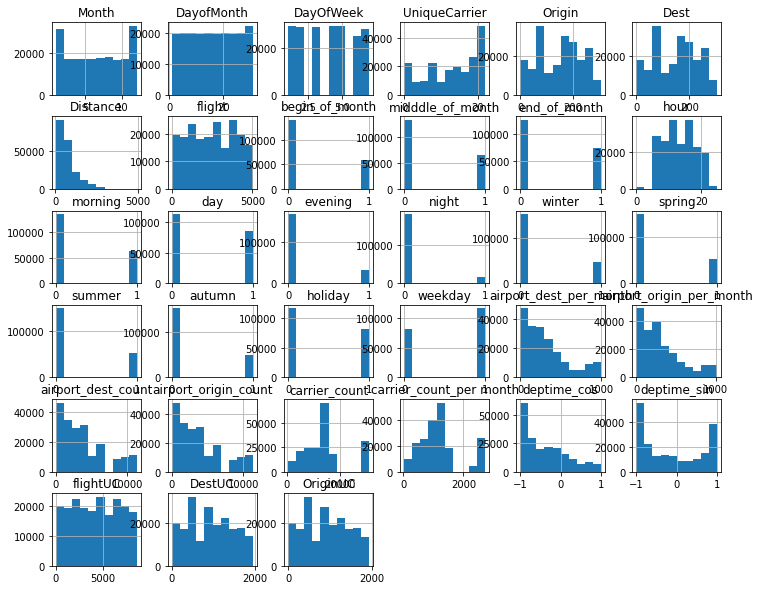

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,10))
ax = fig.gca()
_ = full_df.hist(ax = ax)


Split the new full dataframe into X_train and X_test. 

In [30]:
X_train = full_df[:train_df.shape[0]]
X_test = full_df[train_df.shape[0]:]

Create a list of the categorical features.

In [31]:
categorical_features = ['Month',  'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']

Let's build a light GBM model to test the bayesian optimizer.

### [LightGBM](https://lightgbm.readthedocs.io/en/latest/) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

First, we define the function we want to maximize and that will count cross-validation metrics of lightGBM for our parameters.

Some params such as num_leaves, max_depth, min_child_samples, min_data_in_leaf should be integers.

In [32]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lightgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['auc-mean'][-1]

Apply the Bayesian optimizer to the function we created in the previous step to identify the best hyperparameters. We will run 10 iterations and set init_points = 2.


In [33]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)
                                                })

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=1259, min_child_samples=6182 will be ignored. Current value: min_data_in_leaf=1259
|  1        |  0.7427   |  0.03781  |  0.0122   |  55.09    |  6.183e+0 |  1.26e+03 |  688.8    |
|  2        |  0.7434   |  0.03845  |  0.02674  |  61.26    |  5.155e+0 |  1.725e+0 |  2.39e+03 |
|  3        |  0.725    |  0.04504  |  0.03414  |  19.76    |  6.425e+0 |  602.4    |  3.428e+0 |
|  4        |  0.7432   |  0.01902  |  0.00651  |  23.36    |  7.982e+0 |  1.995e+0 |  696.7    |
|  5        |  0.7291   |  0.03719  |  0.02109  |  59.36    |  1.304e+0 |  906.0    |  249.5    |
|  6        |  0.7245   |  0.02554  |  0.02869  |  29.16    |  4.387e+0 |  613.6    |  2.57e+03 |
|  7        |  0.7422   |  0.01317  |  0.01539  |  10.04    |  3.102e+0 |  1.176e+0 |  1

 **<font color='teal'> Print the best result by using the '.max' function.</font>**

In [34]:
lgbBO.max

{'target': 0.7434459736507826,
 'params': {'lambda_l1': 0.0016303273388589613,
  'lambda_l2': 0.010310079041175264,
  'max_depth': 12.968999880743908,
  'min_child_samples': 4927.822444069941,
  'min_data_in_leaf': 1498.7315372543567,
  'num_leaves': 2817.1385055735213}}

Review the process at each step by using the '.res[0]' function.

In [39]:
lgbBO.res

[{'target': 0.7427110558761476,
  'params': {'lambda_l1': 0.03781355594048594,
   'lambda_l2': 0.012204480532876528,
   'max_depth': 55.09232961052355,
   'min_child_samples': 6182.560095889998,
   'min_data_in_leaf': 1259.8711923026037,
   'num_leaves': 688.8082054615691}},
 {'target': 0.7433693284508501,
  'params': {'lambda_l1': 0.0384479383420923,
   'lambda_l2': 0.026738698688059483,
   'max_depth': 61.25579811685433,
   'min_child_samples': 5155.304576124361,
   'min_data_in_leaf': 1724.5246878553764,
   'num_leaves': 2389.7067945673953}},
 {'target': 0.724966352493993,
  'params': {'lambda_l1': 0.04504141236527301,
   'lambda_l2': 0.03414136976638829,
   'max_depth': 19.76421858167511,
   'min_child_samples': 6425.045142296527,
   'min_data_in_leaf': 602.4197611417417,
   'num_leaves': 3427.625593147281}},
 {'target': 0.7432150648441804,
  'params': {'lambda_l1': 0.019024716237250373,
   'lambda_l2': 0.006509504610436834,
   'max_depth': 23.35740589355026,
   'min_child_samples'